# Iterative Problems

Iterative problems refers to the objectives that can run in multiple iterations and in each of the iteration, it can report the current metrics and may also checkpoint and resume. To optimize iterative problems, the main approach to early stop the bad trials, and move compute resource to the promising ones.

Deep learning models are the most typical iterative problems in parameter optimization.

In [1]:
from fugue_notebook import setup
setup()

<IPython.core.display.Javascript object>

In [2]:
from tune import TUNE_OBJECT_FACTORY
TUNE_OBJECT_FACTORY.set_temp_path("/tmp")

## Reorganize Your Keras Model Code

In this demo we are going to use Keras Model as our iterative problem example. To develop a keras model, we need to do several things such as construct the model, compile and fit. In order to use tune package for a keras problem, you need to fill out our template class KerasTrainingSpec, it doesn't really add anything to your logic, but it keeps your code organized. Plus with the template, you can still use it in common way - to train it on local machine given epochs. You will not lose anything or add any unnecessary thing by implementing this class.

In [3]:
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import boston_housing

from tune_tensorflow import KerasTrainingSpec

class HousingSpec(KerasTrainingSpec):
    def __init__(self, params, dfs):
        assert 0 == len(dfs)
        super().__init__(params, dfs)
        (self.train_data, self.train_targets), (
            self.test_data,
            self.test_targets,
        ) = boston_housing.load_data()

    def get_model(self):
        l1, l2 = self.params.simple_value["l1"], self.params.simple_value["l2"]
        model = models.Sequential()
        model.add(
            layers.Dense(l1, activation="relu", input_shape=(self.train_data.shape[1],))
        )
        model.add(layers.Dense(l2, activation="relu"))
        model.add(layers.Dense(1))
        return model

    def get_compile_params(self):
        return dict(optimizer="rmsprop", loss="mse", metrics=["mae"])

    def get_fit_params(self):
        return [self.train_data, self.train_targets], dict(
            validation_data=(self.test_data, self.test_targets), shuffle=True
        )

    def get_fit_metric(self, history):
        return float(history.history["val_mae"][-1])

    def generate_sort_metric(self, metric: float) -> float:
        return metric

Notice that you can also define how to save and load the current model in the template. The default way to save is to only save the weights. The default way to load is to call get_model and then load weights.

For iterative problems, we will separate the execution to several rungs, each rung for a deep learning model will contain several epochs. Save and load is on rung level, not on epoch level. So if you want to checkpoint on each epoch, you can add your own callbacks.

For deep learning models, it normally uses GPU to train, and it can be expensive, so before tuning, it's important to test with your local CPU or GPU to see if the training spec can run one rung successfully. To do that, you only need to call compute_sort_metric. It will produce the final output metric used for tuning. The metric must be smaller better. You can implement generate_sort_metric for different type of metrics. For errors they are already smaller better, but for things like precision, you should return the negative value to be smaller better.m

In [4]:
spec = HousingSpec(dict(l1=8, l2=16),dfs={})
spec.compute_sort_metric(epochs=3)

2022-01-17 19:54:08.523834: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-17 19:54:08.524223: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


Train on 404 samples, validate on 102 samples
Epoch 1/3
404/404 [==============================] - 1s 2ms/sample - loss: 27413.4412 - mae: 160.3242 - val_loss: 15522.5603 - val_mae: 121.8566
Epoch 2/3
404/404 [==============================] - 0s 98us/sample - loss: 10894.1324 - mae: 100.2093 - val_loss: 6229.4459 - val_mae: 74.7453
Epoch 3/3
404/404 [==============================] - 0s 96us/sample - loss: 4404.7381 - mae: 60.2880 - val_loss: 2329.2183 - val_mae: 42.2783


42.27825927734375

## Define the simplest case and run

After calling compute_sort_metric, we know it works fine for each run. So now let's define the search space and start tuning.

In [5]:
import pandas as pd

from tune import Space, Grid, Rand, RandInt, Choice

from tune_tensorflow import (
    keras_space,
    suggest_keras_models_by_continuous_asha,
    suggest_keras_models_by_hyperband,
    suggest_keras_models_by_sha,
)

If you have read the tutorial for non-iterative problems, you will find the utility functions are highly consistent. For keras_space, just like sk_space, you specify the spec class type, followed by hyperparameters. The following space will contain only two configurations.

In [6]:
space = keras_space(HousingSpec, l1=Grid(8, 16), l2=16)

# using successive halving to search in the space
result = suggest_keras_models_by_sha(
    space,
    plan=[(2.0,1)]  # for each of the two configurations, we run 2 epochs, and select 1 as the final result based on sorted_metric.
)

result


NativeExecutionEngine doesn't respect num_partitions ROWCOUNT


Train on 404 samples, validate on 102 samples
Epoch 1/2
404/404 [==============================] - 1s 1ms/sample - loss: 2440.3781 - mae: 42.7642 - val_loss: 520.0272 - val_mae: 18.5519
Epoch 2/2
404/404 [==============================] - 0s 98us/sample - loss: 254.3057 - mae: 12.8793 - val_loss: 179.2907 - val_mae: 10.4215
Train on 404 samples, validate on 102 samples
Epoch 1/2
404/404 [==============================] - 1s 2ms/sample - loss: 590.6521 - mae: 13.9741 - val_loss: 212.2144 - val_mae: 9.9724
Epoch 2/2
404/404 [==============================] - 0s 133us/sample - loss: 190.8393 - mae: 9.0388 - val_loss: 106.4788 - val_mae: 7.5445


[{'trial': {'trial_id': 'b0961e02-bd7c-5166-8657-254d487e0262', 'params': {'__space__model': '__main__.HousingSpec', 'l1': 16, 'l2': 16}, 'metadata': {}, 'keys': []}, 'metric': 7.54452657699585, 'params': {'__space__model': '__main__.HousingSpec', 'l1': 16, 'l2': 16}, 'metadata': {}, 'cost': 2.0, 'rung': 0, 'sort_metric': 7.54452657699585, 'log_time': datetime.datetime(2022, 1, 17, 19, 54, 11, 122638)}]

## Successive Halving

If you don't have a lot of computing resource, for example you are tuning using your own machine with just 1 GPU, then, successive halving is a great choice. In this implementation, the models will be saved to disk after each rung, and will be retrived at the beginning of next rung if promoted.

In [7]:
import tensorflow as tf
tf.__version__

'2.0.0'

In [8]:
%%time
space = keras_space(HousingSpec, l1=RandInt(8,32), l2=RandInt(8,32))

result = suggest_keras_models_by_sha(
    space.sample(16,0),
    plan=[(1.0,8),(2.0,4),(4.0,2),(8.0,1)],  # a traditional successive halving plan, you can invent your own plan
    top_n=2, # we only keep up to 2 best results
)

result

NativeExecutionEngine doesn't respect num_partitions ROWCOUNT


Train on 404 samples, validate on 102 samples
404/404 [==============================] - 1s 2ms/sample - loss: 1319.9363 - mae: 30.7002 - val_loss: 244.9719 - val_mae: 12.9941
Train on 404 samples, validate on 102 samples
404/404 [==============================] - 1s 2ms/sample - loss: 500.6304 - mae: 17.9309 - val_loss: 233.3478 - val_mae: 12.2873
Train on 404 samples, validate on 102 samples
404/404 [==============================] - 1s 2ms/sample - loss: 12419.4504 - mae: 102.1658 - val_loss: 2256.5096 - val_mae: 46.1901
Train on 404 samples, validate on 102 samples
404/404 [==============================] - 1s 2ms/sample - loss: 8233.0814 - mae: 82.0592 - val_loss: 1704.8914 - val_mae: 37.3571
Train on 404 samples, validate on 102 samples
404/404 [==============================] - 1s 2ms/sample - loss: 3593.6414 - mae: 40.9148 - val_loss: 1249.0543 - val_mae: 25.7184
Train on 404 samples, validate on 102 samples
404/404 [==============================] - 1s 2ms/sample - loss: 636.7

NativeExecutionEngine doesn't respect num_partitions ROWCOUNT


Train on 404 samples, validate on 102 samples
Epoch 2/3
404/404 [==============================] - 1s 2ms/sample - loss: 120.4326 - mae: 8.2631 - val_loss: 64.8577 - val_mae: 6.2104
Epoch 3/3
404/404 [==============================] - 0s 100us/sample - loss: 68.8768 - mae: 6.0364 - val_loss: 79.5332 - val_mae: 7.7276
Train on 404 samples, validate on 102 samples
Epoch 2/3
404/404 [==============================] - 1s 2ms/sample - loss: 169.3502 - mae: 10.0419 - val_loss: 94.6301 - val_mae: 7.5048
Epoch 3/3
404/404 [==============================] - 0s 98us/sample - loss: 86.7536 - mae: 7.2502 - val_loss: 77.5732 - val_mae: 7.1749
Train on 404 samples, validate on 102 samples
Epoch 2/3
404/404 [==============================] - 1s 2ms/sample - loss: 101.8134 - mae: 7.3988 - val_loss: 79.9524 - val_mae: 6.5653
Epoch 3/3
404/404 [==============================] - 0s 106us/sample - loss: 79.3774 - mae: 6.3908 - val_loss: 82.5980 - val_mae: 7.5088
Train on 404 samples, validate on 102 sampl

NativeExecutionEngine doesn't respect num_partitions ROWCOUNT


Train on 404 samples, validate on 102 samples
Epoch 4/7
404/404 [==============================] - 1s 2ms/sample - loss: 72.0936 - mae: 6.1744 - val_loss: 66.9929 - val_mae: 6.1877
Epoch 5/7
404/404 [==============================] - 0s 112us/sample - loss: 62.9729 - mae: 5.6834 - val_loss: 88.0643 - val_mae: 6.9307
Epoch 6/7
404/404 [==============================] - 0s 115us/sample - loss: 65.6215 - mae: 5.6781 - val_loss: 65.6765 - val_mae: 6.0891
Epoch 7/7
404/404 [==============================] - 0s 112us/sample - loss: 60.2537 - mae: 5.5051 - val_loss: 80.3885 - val_mae: 6.5533
Train on 404 samples, validate on 102 samples
Epoch 4/7
404/404 [==============================] - 1s 2ms/sample - loss: 82.5100 - mae: 6.6947 - val_loss: 79.3555 - val_mae: 7.2332
Epoch 5/7
404/404 [==============================] - 0s 127us/sample - loss: 76.0593 - mae: 6.4427 - val_loss: 93.5321 - val_mae: 8.2037
Epoch 6/7
404/404 [==============================] - 0s 108us/sample - loss: 70.1939 - mae

NativeExecutionEngine doesn't respect num_partitions ROWCOUNT


Train on 404 samples, validate on 102 samples
Epoch 8/15
404/404 [==============================] - 1s 2ms/sample - loss: 88.7617 - mae: 6.4368 - val_loss: 62.2813 - val_mae: 5.8132
Epoch 9/15
404/404 [==============================] - 0s 98us/sample - loss: 67.9098 - mae: 6.2745 - val_loss: 57.2800 - val_mae: 5.8389
Epoch 10/15
404/404 [==============================] - 0s 97us/sample - loss: 60.1481 - mae: 5.6344 - val_loss: 59.0031 - val_mae: 5.6075
Epoch 11/15
404/404 [==============================] - 0s 108us/sample - loss: 61.0459 - mae: 5.9227 - val_loss: 89.7350 - val_mae: 7.0892
Epoch 12/15
404/404 [==============================] - 0s 99us/sample - loss: 62.9239 - mae: 5.9813 - val_loss: 69.6226 - val_mae: 6.1424
Epoch 13/15
404/404 [==============================] - 0s 98us/sample - loss: 61.2087 - mae: 5.7546 - val_loss: 62.4240 - val_mae: 6.2600
Epoch 14/15
404/404 [==============================] - 0s 97us/sample - loss: 60.2624 - mae: 5.9038 - val_loss: 55.9667 - val_ma

[{'trial': {'trial_id': 'fb22d339-41ac-569b-95b1-7c9c4ce8148a', 'params': {'__space__model': '__main__.HousingSpec', 'l1': 21, 'l2': 31}, 'metadata': {}, 'keys': []}, 'metric': 5.396399974822998, 'params': {'__space__model': '__main__.HousingSpec', 'l1': 21, 'l2': 31}, 'metadata': {}, 'cost': 8.0, 'rung': 3, 'sort_metric': 5.396399974822998, 'log_time': datetime.datetime(2022, 1, 17, 19, 54, 35, 701089)},
 {'trial': {'trial_id': '61299f88-d921-5c5c-a19e-7885e63f6add', 'params': {'__space__model': '__main__.HousingSpec', 'l1': 21, 'l2': 8}, 'metadata': {}, 'keys': []}, 'metric': 5.441264629364014, 'params': {'__space__model': '__main__.HousingSpec', 'l1': 21, 'l2': 8}, 'metadata': {}, 'cost': 8.0, 'rung': 3, 'sort_metric': 5.441264629364014, 'log_time': datetime.datetime(2022, 1, 17, 19, 54, 36, 678024)}]

## Run with Spark

If you have a Spark/Dask cluster, you can easily scale your search by providing a different execution_engine and execution_engine_conf. But if you are training a deep learning model, nomrally you need a GPU for each worker. How to make Spark and Dask start workers with GPU is a question about infrastructure. We can't provide a guidance here because it very environment specific.

For this case we only use CPU, so we can use the local spark to utilize the 4 CPUs.

In [9]:
from pyspark import SparkContext, SparkConf
from pyspark.sql.session import SparkSession
from fugue_spark import SparkExecutionEngine

fconf = {
    "fugue.rpc.server": "fugue.rpc.flask.FlaskRPCServer",
    "fugue.rpc.flask_server.host": "0.0.0.0",
    "fugue.rpc.flask_server.port": "1234",
    "fugue.rpc.flask_server.timeout": "2 sec",
}

conf = SparkConf().set("spark.ui.showConsoleProgress", "false")
sc = SparkContext(appName="Tuning", conf=conf)
spark = SparkExecutionEngine(SparkSession(sc), conf=fconf)


Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/01/17 19:54:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [10]:
%%time

space = keras_space(HousingSpec, l1=RandInt(8,32), l2=RandInt(8,32))

result = suggest_keras_models_by_sha(
    space.sample(16,0),
    plan=[(1.0,8),(2.0,4),(4.0,2),(8.0,1)],
    execution_engine="spark",
    top_n=2,
)

result

2022-01-17 19:55:15.734290: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-17 19:55:15.739203: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.
2022-01-17 19:55:15.738501: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-17 19:55:15.741943: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use

404/404 [==============================] - 2s 5ms/sample - loss: 108.1166 - mae: 7.6912 - val_loss: 106.0189 - val_mae: 7.6417
Epoch 3/3
404/404 [==============================] - 2s 4ms/sample - loss: 79.0589 - mae: 6.3961 - val_loss: 72.6850 - val_mae: 6.3838
Epoch 3/3
404/404 [==============================] - 2s 5ms/sample - loss: 120.2889 - mae: 8.0981 - val_loss: 100.1122 - val_mae: 7.7225
Epoch 3/3
404/404 [==============================] - 2s 4ms/sample - loss: 70.1822 - mae: 6.0738 - val_loss: 64.3547 - val_mae: 5.7275
Epoch 3/3
404/404 [==============================] - 2s 5ms/sample - loss: 89.2055 - mae: 6.7816 - val_loss: 70.8787 - val_mae: 6.2733
Epoch 3/3
404/404 [==============================] - 0s 503us/sample - loss: 72.3159 - mae: 5.8794 - val_loss: 72.1742 - val_mae: 6.1896
2022-01-17 19:55:37.540533: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance cr

CPU times: user 428 ms, sys: 132 ms, total: 560 ms
Wall time: 1min 6s


[{'trial': {'trial_id': '5679b586-e31c-5b98-84ea-2a779201a450', 'params': {'__space__model': '__main__.HousingSpec', 'l1': 24, 'l2': 27}, 'metadata': {}, 'keys': []}, 'metric': 5.857834815979004, 'params': {'__space__model': '__main__.HousingSpec', 'l1': 24, 'l2': 27}, 'metadata': {}, 'cost': 8.0, 'rung': 3, 'sort_metric': 5.857834815979004, 'log_time': datetime.datetime(2022, 1, 17, 19, 55, 57, 783590)},
 {'trial': {'trial_id': '90c3d0d6-d3c6-54f1-b59a-fdd7233e83b2', 'params': {'__space__model': '__main__.HousingSpec', 'l1': 31, 'l2': 18}, 'metadata': {}, 'keys': []}, 'metric': 6.191352367401123, 'params': {'__space__model': '__main__.HousingSpec', 'l1': 31, 'l2': 18}, 'metadata': {}, 'cost': 8.0, 'rung': 3, 'sort_metric': 6.191352367401123, 'log_time': datetime.datetime(2022, 1, 17, 19, 55, 57, 785641)}]

## Run with realtime monitoring

On notebooks, it's important and fun to track the progress in real time. In tune you can enable realtime callback with a monitor to watch the progress. There are 3 types of built in monitors for iterative problems:

1. ts to monitor the up-to-date best metric collected
2. hist to motitor the histogram of metrics collected
3. rungs to monitor the trails performance at each rung

Notice to enable realtime monitoring, you must enable callback in execution_engine_conf.

In this example, we also added a warmup period. So the first rung will run more epochs before discarding bad ones.

In [11]:
from typing import Optional
from tune import Monitor
from tune_notebook import (
    NotebookSimpleHist,
    NotebookSimpleRungs,
    NotebookSimpleTimeSeries,
    PrintBest,
)

def to_monitor(obj) -> Optional[Monitor]:
    if obj is None:
        return None
    if isinstance(obj, Monitor):
        return obj
    if isinstance(obj, str):
        if obj == "hist":
            return NotebookSimpleHist()
        if obj == "rungs":
            return NotebookSimpleRungs()
        if obj == "ts":
            return NotebookSimpleTimeSeries()
        if obj == "text":
            return PrintBest()
    raise NotImplementedError(obj)

TUNE_OBJECT_FACTORY.set_monitor_converter(to_monitor)

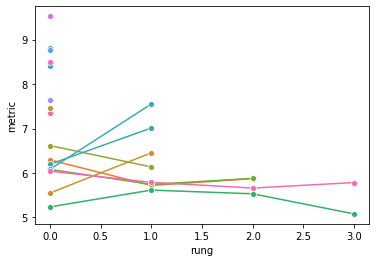

[] 5.078456878662109 {'trial': {'trial_id': 'bcf35cc2-c02e-5d5f-b501-24c66ccae969', 'params': {'__space__model': '__main__.HousingSpec', 'l1': 21, 'l2': 29}, 'metadata': {}, 'keys': []}, 'metric': 5.078456878662109, 'params': {'__space__model': '__main__.HousingSpec', 'l1': 21, 'l2': 29}, 'metadata': {}, 'cost': 8.0, 'rung': 3, 'sort_metric': 5.078456878662109, 'log_time': datetime.datetime(2022, 1, 17, 19, 56, 35, 199312)}
CPU times: user 34.5 s, sys: 1.84 s, total: 36.4 s
Wall time: 33.8 s


[{'trial': {'trial_id': 'bcf35cc2-c02e-5d5f-b501-24c66ccae969', 'params': {'__space__model': '__main__.HousingSpec', 'l1': 21, 'l2': 29}, 'metadata': {}, 'keys': []}, 'metric': 5.078456878662109, 'params': {'__space__model': '__main__.HousingSpec', 'l1': 21, 'l2': 29}, 'metadata': {}, 'cost': 8.0, 'rung': 3, 'sort_metric': 5.078456878662109, 'log_time': datetime.datetime(2022, 1, 17, 19, 56, 35, 199312)},
 {'trial': {'trial_id': '1853040c-56d3-5f9d-9fb5-0b1747648f14', 'params': {'__space__model': '__main__.HousingSpec', 'l1': 22, 'l2': 21}, 'metadata': {}, 'keys': []}, 'metric': 5.784449100494385, 'params': {'__space__model': '__main__.HousingSpec', 'l1': 22, 'l2': 21}, 'metadata': {}, 'cost': 8.0, 'rung': 3, 'sort_metric': 5.784449100494385, 'log_time': datetime.datetime(2022, 1, 17, 19, 56, 36, 338849)}]

In [12]:
%%time
space = keras_space(HousingSpec, l1=RandInt(8,32), l2=RandInt(8,32))
warmup = 4

result = suggest_keras_models_by_sha(
    space.sample(16,0),
    plan=[(warmup+1.0,8),(2.0,4),(4.0,2),(8.0,1)],
    execution_engine_conf={"callback":True},
    monitor="rungs",
    top_n=2,
)

result

## Hyperband

Traditional Hyperband is roughly a grid search of traditional Successive Halving. In our solution, we generalized Hyperband. You can provide the plan by a two dimensional array, and you can invent your own!

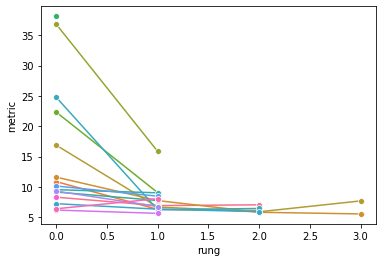

[] 5.534700870513916 {'trial': {'trial_id': '360e486c-6d27-5abc-bb8d-c9bd388e62c3', 'params': {'__space__model': '__main__.HousingSpec', 'l1': 25, 'l2': 28}, 'metadata': {}, 'keys': []}, 'metric': 5.534700870513916, 'params': {'__space__model': '__main__.HousingSpec', 'l1': 25, 'l2': 28}, 'metadata': {}, 'cost': 8.0, 'rung': 3, 'sort_metric': 5.534700870513916, 'log_time': datetime.datetime(2022, 1, 17, 19, 57, 15, 810145)}
CPU times: user 4.08 s, sys: 452 ms, total: 4.53 s
Wall time: 1min 38s


[{'trial': {'trial_id': '360e486c-6d27-5abc-bb8d-c9bd388e62c3', 'params': {'__space__model': '__main__.HousingSpec', 'l1': 25, 'l2': 28}, 'metadata': {}, 'keys': []}, 'metric': 5.534700870513916, 'params': {'__space__model': '__main__.HousingSpec', 'l1': 25, 'l2': 28}, 'metadata': {}, 'cost': 8.0, 'rung': 3, 'sort_metric': 5.534700870513916, 'log_time': datetime.datetime(2022, 1, 17, 19, 57, 15, 810145)},
 {'trial': {'trial_id': 'deef37ff-4cff-5de3-8320-fc5246922a74', 'params': {'__space__model': '__main__.HousingSpec', 'l1': 18, 'l2': 19}, 'metadata': {}, 'keys': []}, 'metric': 5.626887321472168, 'params': {'__space__model': '__main__.HousingSpec', 'l1': 18, 'l2': 19}, 'metadata': {}, 'cost': 8.0, 'rung': 1, 'sort_metric': 5.626887321472168, 'log_time': datetime.datetime(2022, 1, 17, 19, 58, 0, 672435)}]

In [13]:
%%time
result = suggest_keras_models_by_hyperband(
    space.sample(16,0),
    plans=[
        [(1.0,8),(2.0,4),(4.0,2),(8.0,1)],
        [(2.0,4),(4.0,2),(8.0,1)],
        [(4.0,2),(8.0,1)],
    ],
    execution_engine=spark,
    execution_engine_conf={"callback":True},
    monitor="rungs",
    top_n=2,
)

result

## Asynchronous Success Halving

ASHA is an improved version of SHA. The idea is simple but the impact is big. Although on this Kaggle CPU instance, we can't show the full power of ASHA, but in practice, if you have a decent amount of compute resource, ASHA will out perform SHA and Hyperband on almost every aspect: searching speed, cost, output model performance.

Even on this machine, you can see the time take for ASHA is a lot less than SHA with more searches done.

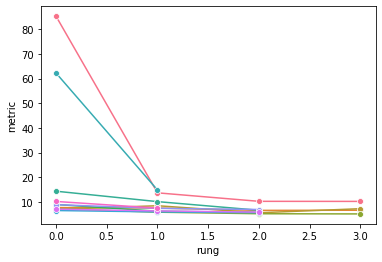

[] 5.175924777984619 {'trial': {'trial_id': 'f63f8520-5581-52af-b8bd-8d2d23b7e831', 'params': {'__space__model': '__main__.HousingSpec', 'l1': 21, 'l2': 11}, 'metadata': {}, 'keys': []}, 'metric': 5.175924777984619, 'params': {'__space__model': '__main__.HousingSpec', 'l1': 21, 'l2': 11}, 'metadata': {}, 'cost': 8.0, 'rung': 3, 'sort_metric': 5.175924777984619, 'log_time': datetime.datetime(2022, 1, 17, 19, 58, 28, 403762)}


404/404 [==============================] - 1s 3ms/sample - loss: 62.7986 - mae: 5.4580 - val_loss: 63.1626 - val_mae: 6.0242
Epoch 10/16
404/404 [==============================] - 0s 132us/sample - loss: 56.0847 - mae: 5.1227 - val_loss: 85.6432 - val_mae: 7.7297
Epoch 11/16
404/404 [==============================] - 0s 118us/sample - loss: 56.0394 - mae: 5.2751 - val_loss: 58.2662 - val_mae: 5.5350
Epoch 12/16
404/404 [==============================] - 0s 111us/sample - loss: 55.7567 - mae: 5.1046 - val_loss: 65.8581 - val_mae: 5.8243
Epoch 13/16
404/404 [==============================] - 0s 108us/sample - loss: 52.1970 - mae: 4.9439 - val_loss: 68.7707 - val_mae: 6.0233
Epoch 14/16
404/404 [==============================] - 0s 109us/sample - loss: 54.3618 - mae: 5.1161 - val_loss: 88.8879 - val_mae: 8.0009
Epoch 15/16
404/404 [==============================] - 0s 139us/sample - loss: 53.7091 - mae: 5.2220 - val_loss: 60.4695 - val_mae: 5.5697
Epoch 16/16
404/404 [====================

CPU times: user 1.42 s, sys: 191 ms, total: 1.61 s
Wall time: 25.2 s


[{'trial': {'trial_id': 'f63f8520-5581-52af-b8bd-8d2d23b7e831', 'params': {'__space__model': '__main__.HousingSpec', 'l1': 21, 'l2': 11}, 'metadata': {}, 'keys': []}, 'metric': 5.175924777984619, 'params': {'__space__model': '__main__.HousingSpec', 'l1': 21, 'l2': 11}, 'metadata': {}, 'cost': 8.0, 'rung': 3, 'sort_metric': 5.175924777984619, 'log_time': datetime.datetime(2022, 1, 17, 19, 58, 28, 403762)},
 {'trial': {'trial_id': '00dc3281-97eb-5e4f-a486-32d8dedc674f', 'params': {'__space__model': '__main__.HousingSpec', 'l1': 10, 'l2': 22}, 'metadata': {}, 'keys': []}, 'metric': 5.658406734466553, 'params': {'__space__model': '__main__.HousingSpec', 'l1': 10, 'l2': 22}, 'metadata': {}, 'cost': 4.0, 'rung': 2, 'sort_metric': 5.658406734466553, 'log_time': datetime.datetime(2022, 1, 17, 19, 58, 26, 639210)}]

In [14]:
%%time
warmup = 1

result = suggest_keras_models_by_continuous_asha(
    space.sample(64,0),  # ASHA will use up to 64 samples
    plan=[(warmup+1.0,8),(2.0,4),(4.0,2),(8.0,1)],
    execution_engine=spark,
    execution_engine_conf={"callback":True},
    monitor="rungs",
    top_n=2,
)

result

## Summary

Successive Halving and Hyperband are great if you don't have a lot of compute resource. ASHA is great if have sufficient compute resource.

We have generalized all these algorithms so you can fully customize the tuning plan by just providing arrays. And the process is scale agnostic and platform agnostice, as long as you have a distributed framework available, you can easily scale up the search while tracking the progress in real time.